<a href="https://colab.research.google.com/github/swap-10/Dense-DNN-From-Scratch/blob/main/DenseDNNScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully Connected Deep Neural Network with NumPy

# Constructing the Neural Net

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import sys
import glob
import h5py
import cv2
import csv

np.random.seed()

In [2]:
def sigmoid(Z):

  s = 1 / np.exp(Z)
  s = 1 / (1 + s) 
  cache_act = Z

  return s, cache_act


def relu(Z):

  r = np.maximum(0, Z)
  cache_act = Z

  return r, cache_act


def sigmoid_derivative(Z):

  d_sigmoid = np.multiply(Z, (1 - Z))

  return d_sigmoid


def relu_derivative(Z):

  d_relu = Z
  d_relu[d_relu<=0] = 0
  d_relu[d_relu>0] = 1

  return d_relu


def sigmoid_backprop(dA, cache_act):
  
  Z = cache_act
  dZ = np.multiply(dA, sigmoid_derivative(Z))

  return dZ


def relu_backprop(dA, cache_act):
  
  Z = cache_act
  dZ = np.multiply(dA, relu_derivative(Z))

  return dZ


In [3]:
a = [[1, 2],
     [3, 4],
     [5, 6]]

b = [[11, 12],
      [13, 14],
      [15, 16]]

print(np.multiply(a,b))

[[11 24]
 [39 56]
 [75 96]]


In [4]:
def init_params(layer_dims):
  
  params = {}
  L = len(layer_dims)

  for i in range(1, L):
    params[f"W%d" %i] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.03
    params[f"b%d" %i] = np.zeros((layer_dims[i],1))
  
  return params

In [6]:
def forward_nonact(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)

  return Z, cache

def forward_act(A_pre, W, b, activation):
  
  if activation == "sigmoid":
    Z, cache_nonact = forward_nonact(A_pre, W, b)
    A, cache_act = sigmoid(Z)

  elif activation == "relu":
    Z, cache_nonact = forward_nonact(A_pre, W, b)
    A, cache_act = relu(Z)

  cache = (cache_nonact, cache_act)

  return A, cache

In [7]:
def forward_prop(X, params):

  L = len(params) // 2
  cache_accumulate = []
  A = X  # First layer

  for i in range(1, L):
    A_pre = A
    A, cache = forward_act(
                          A_pre,
                          params[f"W%d" %i], params[f"b%d" %i],
                          activation="relu"
                          )
    cache_accumulate.append(cache)

  A_L, cache = forward_act(
                           A,
                           params[f"W%d" %L],
                           params[f"b%d" %L],
                           activation="sigmoid"
                          )
  cache_accumulate.append(cache)

  return A_L, cache_accumulate



In [8]:
def compute_cost(A_L, Y):

  m = Y.shape[1]  # Assuming Y is in form of (1, num_of_training_examples)

  cost = (-1/m) * np.sum( (np.multiply(np.log(A_L), Y) + np.multiply(np.log(1-A_L), (1-Y))), axis=1, keepdims=True)
  cost = np.sum(cost)
  cost = np.squeeze(cost)

  return cost

In [9]:
def backward_nonact(dZ, cache_nonact):

  A_pre, W, b = cache_nonact
  m = A_pre.shape[1]  # All A.shape[1] will have same value (m)

  dW = (1/m) * np.dot(dZ, A_pre.T)
  db = (1/m) *  np.sum(dZ, axis=1, keepdims=True)
  dA_pre = np.dot(W.T, dZ)

  return dA_pre, dW, db


def backward_act(dA, cache, activation):

  cache_nonact, cache_act = cache

  if activation == "relu":
    dZ = relu_backprop(dA, cache_act)
    dA_pre, dW, db = backward_nonact(dZ, cache_nonact)

  elif activation == "sigmoid":
    dZ = sigmoid_backprop(dA, cache_act)
    dA_pre, dW, db = backward_nonact(dZ, cache_nonact)

  return dA_pre, dW, db



In [10]:
def backward_prop(A_L, Y, cache_accumulate):

  L = len(cache_accumulate)
  m = A_L.shape[1]
  Y = Y.reshape(A_L.shape)
  grads = {}

  dA_L = - (np.divide(Y, A_L) - np.divide(1 - Y, 1 - A_L))

  cache_cur = cache_accumulate[-1]
  dA_pre_cur, dW_cur, db_cur = backward_act(dA_L, cache_cur, activation="sigmoid")
  grads[f"dA%d" %(L-1)] = dA_pre_cur
  grads[f"dW%d" %L] = dW_cur
  grads[f"db%d" %L] = db_cur

  for i in range(L-2, -1, -1):

    cache_cur = cache_accumulate[i]
    dA_pre_cur, dW_cur, db_cur = backward_act(dA_pre_cur, cache_cur, activation="relu")
    grads[f"dA%d" %i] = dA_pre_cur
    grads[f"dW%d" %(i+1)] = dW_cur
    grads[f"db%d" %(i+1)] = db_cur

  return grads


In [37]:
def update_params(params, grads, learning_rate):

  parameters = params.copy()
  L = len(parameters) // 2

  for i in range(L):

    parameters[f"W%d" %(i+1)] = parameters[f"W%d" %(i+1)] - (learning_rate*grads[f"dW%d" %(i+1)])
    parameters[f"b%d" %(i+1)] = parameters[f"b%d" %(i+1)] - (learning_rate*grads[f"db%d" %(i+1)])

  return parameters



---
---
---

<br>
<br>
<br>
<br>

[Dataset used](https://https://data.mendeley.com/datasets/4drtyfjtfy/1)

# Using the Neural Net

# Data Preparation

<h2> Careful! <h2>

In [68]:
%%bash
rm -rf downloaddata
rm -rf dataset2

In [69]:
%%bash
mkdir downloaddata
wget -O ./downloaddata/images.zip https://data.mendeley.com/public-files/datasets/4drtyfjtfy/files/a03e6097-f7fb-4e1a-9c6a-8923c6a0d3e0/file_downloaded | head
unzip ./downloaddata/images.zip -d ./downloaddata

Archive:  ./downloaddata/images.zip
   creating: ./downloaddata/dataset2/
  inflating: ./downloaddata/dataset2/cloudy1.jpg  
  inflating: ./downloaddata/dataset2/cloudy10.jpg  
  inflating: ./downloaddata/dataset2/cloudy100.jpg  
  inflating: ./downloaddata/dataset2/cloudy101.jpg  
  inflating: ./downloaddata/dataset2/cloudy102.jpg  
  inflating: ./downloaddata/dataset2/cloudy103.jpg  
  inflating: ./downloaddata/dataset2/cloudy104.jpg  
  inflating: ./downloaddata/dataset2/cloudy105.jpg  


--2021-10-08 16:18:28--  https://data.mendeley.com/public-files/datasets/4drtyfjtfy/files/a03e6097-f7fb-4e1a-9c6a-8923c6a0d3e0/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/64a54851-f95a-439d-aff7-3334a684e532 [following]
--2021-10-08 16:18:29--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/64a54851-f95a-439d-aff7-3334a684e532
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.102.56
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.102.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95667925 (91M) [application

In [14]:
%%bash
touch filenames.txt
ls ./downloaddata/dataset2/ > filenames.txt

In [15]:
%%bash
a=1
for i in ./downloaddata/dataset2/cloudy*.jpg;
do
  new=$(printf "./downloaddata/dataset2/cloudy%04d.jpg" "$a") #04 pad to length of 4
  mv -i -- "$i" "$new"
  let a=a+1
done

a=1
for i in ./downloaddata/dataset2/rain*.jpg;
do
  new=$(printf "./downloaddata/dataset2/rain%04d.jpg" "$a") #04 pad to length of 4
  mv -i -- "$i" "$new"
  let a=a+1
done

a=1
for i in ./downloaddata/dataset2/shine*.jpg;
do
  new=$(printf "./downloaddata/dataset2/shine%04d.jpg" "$a") #04 pad to length of 4
  mv -i -- "$i" "$new"
  let a=a+1
done

a=1
for i in ./downloaddata/dataset2/sunrise*.jpg;
do
  new=$(printf "./downloaddata/dataset2/sunrise%04d.jpg" "$a") #04 pad to length of 4
  mv -i -- "$i" "$new"
  let a=a+1
done


In [16]:
%%bash
touch filenames.csv
cd downloaddata/dataset2/
printf "%s\n" * > ../../filenames.csv
cd ../../
shuf filenames.csv > filenames_shuf.csv
head -n 901 filenames_shuf.csv > train_names.csv
tail -n 225 filenames_shuf.csv > test_names.csv

csv files containing names of shuffled data -- done

In [61]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

hf = 'import_images.h5'

with open('train_names.csv', newline='\n') as f:
    reader = csv.reader(f)
    data = list(reader)

print(data[:100])
nfiles = len(data)
print(f'count of image files nfiles={nfiles}')
data = enumerate(data)

# resize all images and load into a single dataset
with h5py.File(hf,'w') as  h5f:
    img_ds = h5f.create_dataset('images_train',shape=(nfiles, IMG_WIDTH, IMG_HEIGHT,3), dtype=int)
    img_labels = h5f.create_dataset('labels_train', shape=(nfiles, 1), dtype=int)
    for (cnt, ifile) in data:
        ifile = "./downloaddata/dataset2/" + ifile[0]
        img = cv2.imread(ifile, cv2.IMREAD_COLOR)
        if img is None:
          continue
        img_resize = cv2.resize( img, (IMG_WIDTH, IMG_HEIGHT))
        img_ds[cnt:cnt+1:,:,:] = img_resize

        if "cloudy" in str(ifile):
          classnum = 0
        elif "rain" in str(ifile):
          classnum = 1
        elif "shine" in str(ifile):
          classnum = 2
        elif "sunrise" in str(ifile):
          classnum = 3
        img_labels[cnt, :] = classnum
        
classnames = ["cloudy", "rain", "shine", "sunrise"]

[['rain0028.jpg'], ['sunrise0318.jpg'], ['shine0179.jpg'], ['cloudy0127.jpg'], ['sunrise0059.jpg'], ['shine0196.jpg'], ['sunrise0336.jpg'], ['cloudy0161.jpg'], ['sunrise0080.jpg'], ['cloudy0290.jpg'], ['shine0029.jpg'], ['sunrise0044.jpg'], ['rain0113.jpg'], ['sunrise0142.jpg'], ['shine0090.jpg'], ['sunrise0034.jpg'], ['rain0142.jpg'], ['shine0217.jpg'], ['sunrise0296.jpg'], ['cloudy0055.jpg'], ['sunrise0249.jpg'], ['cloudy0139.jpg'], ['shine0117.jpg'], ['shine0166.jpg'], ['sunrise0285.jpg'], ['cloudy0048.jpg'], ['sunrise0050.jpg'], ['cloudy0227.jpg'], ['cloudy0225.jpg'], ['shine0216.jpg'], ['rain0166.jpg'], ['shine0159.jpg'], ['cloudy0221.jpg'], ['shine0198.jpg'], ['cloudy0134.jpg'], ['sunrise0107.jpg'], ['shine0122.jpg'], ['sunrise0265.jpg'], ['sunrise0304.jpg'], ['sunrise0245.jpg'], ['sunrise0275.jpg'], ['cloudy0296.jpg'], ['cloudy0009.jpg'], ['cloudy0267.jpg'], ['sunrise0015.jpg'], ['rain0010.jpg'], ['sunrise0147.jpg'], ['cloudy0232.jpg'], ['sunrise0092.jpg'], ['cloudy0295.jpg'], [

<class 'h5py._hl.dataset.Dataset'>


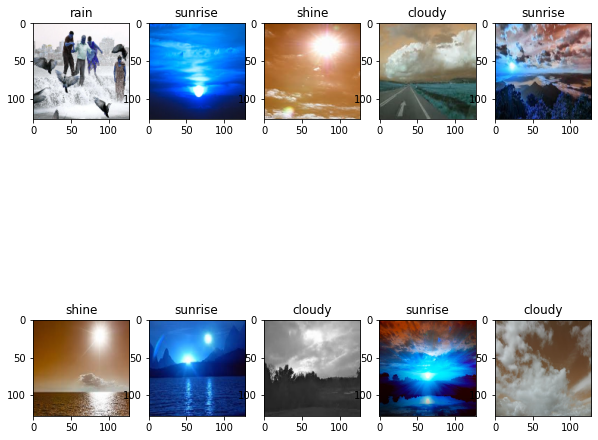

In [18]:
hfile = h5py.File(hf, 'r')
n = hfile.get('images_train')
l = hfile.get('labels_train')
print(type(n))
plt.figure(figsize=(10,10))
for i, img in enumerate(n[:10,:,:,:]):
  plt.subplot(2,5,i+1)
  plt.title(classnames[np.squeeze(l[i,:])])
  plt.imshow(img)
hfile.close()

In [19]:
# https://stackoverflow.com/questions/28170623/how-to-read-hdf5-files-in-python

hfile.close()
hfile = h5py.File(hf, 'r')
i=0
for key in hfile.keys():
  print(key)

group1 = hfile['images_train']
train_images = group1[:]
train_images = np.array(train_images)
print(type(train_images))
print(train_images.shape)
train_images = train_images.reshape(IMG_WIDTH*IMG_HEIGHT*3, -1)
print(train_images.shape)
print(train_images)

group2 = hfile['labels_train']
train_labels = group2[:]
train_labels = np.array(train_labels)
print(type(train_labels))
print(train_labels.shape)
train_labels = train_labels.reshape(1, 901)
print(train_labels.shape)
print(train_labels)
hfile.close()

images_train
labels_train
<class 'numpy.ndarray'>
(901, 128, 128, 3)
(49152, 901)
[[244 239 240 ... 246 247 251]
 [246 248 251 ... 253 255 251]
 [253 255 251 ... 244 239 241]
 ...
 [  0   4  10 ... 106 131  40]
 [ 63  89  18 ...  20   3   7]
 [ 18   2   6 ...   6   5   5]]
<class 'numpy.ndarray'>
(901, 1)
(1, 901)
[[1 3 2 0 3 2 3 0 3 0 2 3 1 3 2 3 1 2 3 0 3 0 2 2 3 0 3 0 0 2 1 2 0 2 0 3
  2 3 3 3 3 0 0 0 3 1 3 0 3 0 1 3 0 3 0 3 0 3 0 1 0 1 0 0 2 0 2 2 1 0 0 0
  0 2 3 3 2 2 0 3 3 3 2 2 1 3 2 0 3 2 1 1 2 1 0 0 3 1 3 2 2 3 3 2 0 3 1 1
  3 0 3 3 2 0 3 2 1 1 3 3 3 3 2 3 0 3 2 1 2 1 2 0 3 0 1 3 0 0 1 3 1 2 1 0
  3 2 1 0 1 3 0 0 3 3 0 1 1 3 2 3 0 2 3 3 1 3 0 3 2 3 0 2 1 0 3 0 1 0 2 3
  1 0 2 0 2 1 3 0 1 2 1 3 0 2 3 0 3 1 3 2 3 2 2 3 0 3 0 0 3 3 0 2 3 0 1 3
  0 3 3 0 0 3 0 2 0 1 2 1 1 0 2 3 0 1 2 3 2 0 0 1 2 2 3 3 0 3 1 1 2 0 2 0
  2 3 3 3 1 3 1 3 1 2 2 3 0 1 1 1 2 3 0 0 0 3 2 2 3 1 0 0 2 1 1 1 1 2 2 3
  3 3 3 3 0 1 2 0 0 3 0 2 1 2 0 3 3 3 2 3 3 1 3 1 2 1 3 1 3 1 3 1 3 0 1 2
  2 2 3 3 2 0 1 2 

In [20]:
layer_dims = [49152, 50, 20, 5, 4]
train_labels = np.multiply(train_labels, np.ones((4, train_labels.shape[1])))
print(train_labels.shape)
print(type(train_labels))
print(train_labels)

(4, 901)
<class 'numpy.ndarray'>
[[1. 3. 2. ... 2. 0. 3.]
 [1. 3. 2. ... 2. 0. 3.]
 [1. 3. 2. ... 2. 0. 3.]
 [1. 3. 2. ... 2. 0. 3.]]


In [21]:
for i in range(train_labels.shape[0]):
  train_labels[i] = [(i==val) for val in train_labels[i]]
print(train_labels.shape)
print(train_labels[0])

(4, 901)
[0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

In [57]:
def model(X, Y, layer_dims, learning_rate=0.001, num_iters=3000, print_cost=False):
  np.random.seed(0)
  costs = []

  params = init_params(layer_dims)

  for i in range(0, num_iters):

    A_L, cache_accumulate = forward_prop(X, params)

    cost = compute_cost(A_L, Y)

    grads = backward_prop(A_L, Y, cache_accumulate)

    params = update_params(params, grads, learning_rate)

    if print_cost and i % 10 == 0 or i == num_iters - 1:
      print("Cost after iteration {}: {}".format(i+1, np.squeeze(cost)))

    if i % 10 == 0 or i == num_iters - 1:
      costs.append(cost)
    

  return params, costs

In [58]:
params, costs = model(train_images, train_labels, layer_dims, num_iters=1, print_cost=False)

Cost after iteration 1: 2.804788852422957


In [60]:
params, costs = model(train_images, train_labels, layer_dims, learning_rate=0.0001, num_iters=500, print_cost=True)

Cost after iteration 1: 2.804788852422957
Cost after iteration 11: 2.8068736888226002
Cost after iteration 21: 2.7957953738858468
Cost after iteration 31: 2.787555662492972
Cost after iteration 41: 2.7824907798359098
Cost after iteration 51: 2.7797473299828144
Cost after iteration 61: 2.7782463058444855
Cost after iteration 71: 2.7773621487281708
Cost after iteration 81: 2.77678933409569
Cost after iteration 91: 2.776409910632497
Cost after iteration 101: 2.7760182250013536
Cost after iteration 111: 2.7757324063591557
Cost after iteration 121: 2.7753749084573514
Cost after iteration 131: 2.77505675352789
Cost after iteration 141: 2.77478442593176
Cost after iteration 151: 2.7745209336383763
Cost after iteration 161: 2.7742948981431144
Cost after iteration 171: 2.774076730465416
Cost after iteration 181: 2.773865269499137
Cost after iteration 191: 2.7736614100902943
Cost after iteration 201: 2.7734639174279074
Cost after iteration 211: 2.7732937392262786
Cost after iteration 221: 2.7731